<a href="https://colab.research.google.com/github/Sanazmoosapour/hackathon/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install hazm --no-deps
!pip install python-crfsuite
!pip install gensim==4.4.0 fasttext-wheel==0.9.2 flashtext==2.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm 0.10.0 requires fasttext-wheel<0.10.0,>=0.9.2, which is not installed.
hazm 0.10.0 requires flashtext<3.0,>=2.7, which is not installed.
hazm 0.10.0 requires gensim<5.0.0,>=4.3.1, which is not installed.
hazm 0.10.0 requires numpy==1.24.3, but you have numpy 2.0.2 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 26.5 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9300 sha256=eb43

In [51]:
from hazm import *
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
df = pd.read_csv("reviews.csv")
df.head()

,review_id,restaurant_id,user_rating,comment_text,created_at
0,1001,1,5,بهترین پیتزای تهران، پنیر کش‌دار و خمیر عالی,2024-11-20T20:15:00
1,1002,1,2,پیتزا سوخته و سس خیلی ترش بود,2024-11-21T21:30:00
2,1003,1,5,پیک سریع و مودب، غذا داغ رسید,2024-11-22T19:45:00
3,1004,1,1,۹۰ دقیقه تاخیر داشت، غذا یخ زده بود,2024-11-23T22:10:00
4,1005,1,4,طعم عالی فقط کمی شور,2024-11-24T20:00:00


In [60]:
normalizer = Normalizer()

def clean_text(x):
    return normalizer.normalize(str(x))

df['comment_text'] = df['comment_text'].apply(clean_text)

In [7]:
df

,review_id,restaurant_id,user_rating,comment_text,created_at
0,1001,1,5,بهترین پیتزای تهران، پنیر کش‌دار و خمیر عالی,2024-11-20T20:15:00
1,1002,1,2,پیتزا سوخته و سس خیلی ترش بود,2024-11-21T21:30:00
2,1003,1,5,پیک سریع و مودب، غذا داغ رسید,2024-11-22T19:45:00
3,1004,1,1,۹۰ دقیقه تاخیر داشت، غذا یخ‌زده بود,2024-11-23T22:10:00
4,1005,1,4,طعم عالی فقط کمی شور,2024-11-24T20:00:00
...,...,...,...,...,...
145,5026,5,5,حتما دوباره می‌گیرم,2024-12-04T20:15:00
146,5027,5,3,گرون برای این کیفیت,2024-12-03T19:50:00
147,5028,5,5,بسته‌بندی عالی,2024-12-02T20:40:00
148,5029,5,2,تاخیر,2024-12-01T21:55:00


In [10]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-snappfood"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [61]:
model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-binary"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [62]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label_id = torch.argmax(probs).item()
    # مدل 0=منفی، 1=خنثی، 2=مثبت
    if label_id == 0:
        return "منفی"
    elif label_id == 1:
        return "مثبت"
    else:
        return "خنثی"


In [64]:
comments = df['comment_text']

for c in comments:
    print(c, "->", predict_sentiment(c))

بهترین پیتزای تهران، پنیر کش‌دار و خمیر عالی -> مثبت
پیتزا سوخته و سس خیلی ترش بود -> منفی
پیک سریع و مودب، غذا داغ رسید -> مثبت
۹۰ دقیقه تاخیر داشت، غذا یخ‌زده بود -> منفی
طعم عالی فقط کمی شور -> مثبت
معمولی بود، چیز خاصی نداشت -> منفی
پیتزا رست بیف معرکه بود -> مثبت
بسته‌بندی افتضاح، همه چیز ریخته بود -> منفی
حجم مواد زیاد و با کیفیت -> مثبت
خوب بود ولی نسبت به قیمت کمی کوچیک -> منفی
غذا سرد و پیک بداخلاق -> منفی
مارگاریتا فوق‌العاده بود -> مثبت
متوسط رو به پایین، قبلا بهتر بود -> مثبت
بسته‌بندی شیک و تمیز -> مثبت
تاخیر ۵۰ دقیقه‌ای و غذای سرد -> منفی
طعم خوب، سرویس عالی -> مثبت
پیتزا خام بود وسطش -> منفی
بهترین پپرونی که خوردم -> مثبت
قیمت بالا نسبت به کیفیت -> منفی
خوب بود، فقط کمی دیر رسید -> مثبت
پیک خیلی محترم بود -> مثبت
سس خیلی کم بود -> منفی
داغ و خوشمزه، ممنون -> مثبت
سفارش اشتباه اومد -> منفی
کیفیت قابل‌قبول -> مثبت
نه خوب نه بد -> مثبت
عالی مثل همیشه -> مثبت
غذا سرد و له‌شده -> مثبت
طعم عالی، ارسال معمولی -> مثبت
همه چی عالی بود -> مثبت
کباب کوبیده حرف نداشت -> مثبت
جوجه با

In [37]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().numpy()
    return cls_embedding

comments = df['comment_text']

embeddings = np.array([get_embedding(c) for c in comments])

/tmp/ipython-input-1471570069.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))


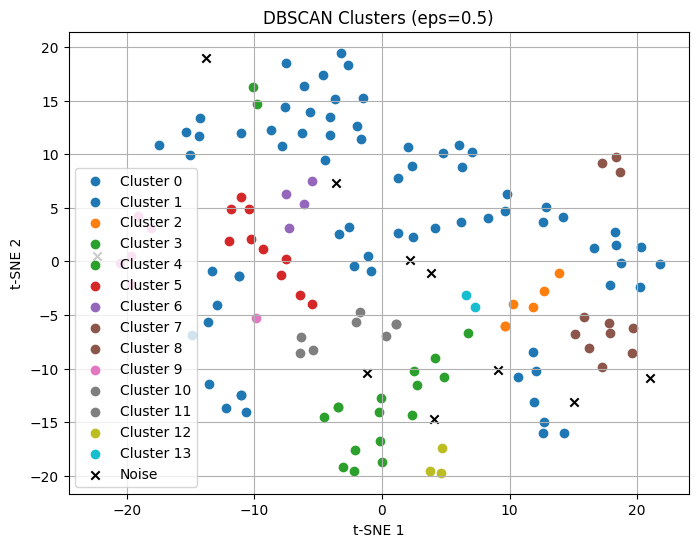

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(embeddings)
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_scaled)
dbscan = DBSCAN(eps=0.51, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
unique_clusters = set(clusters)
colors = plt.cm.get_cmap("tab10", len(unique_clusters))

for cl in unique_clusters:
    idx = clusters == cl
    if cl == -1:
        plt.scatter(X_2d[idx,0], X_2d[idx,1], c='k', marker='x', label='Noise')
    else:
        plt.scatter(X_2d[idx,0], X_2d[idx,1], c=[colors(cl)], label=f'Cluster {cl}')

plt.legend()
plt.title("DBSCAN Clusters (eps=0.5)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

In [52]:
df = pd.DataFrame({
    "comment": comments,
    "cluster": clusters
})

def preprocess(text):
    text = text.replace("\n", " ").strip()
    return text

df['clean_comment'] = df['comment'].apply(preprocess)

for cl in set(clusters):
    if cl == -1:
        continue
    cl_comments = df[df['cluster']==cl]['clean_comment'].tolist()
    vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
    X = vectorizer.fit_transform(cl_comments)
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    word_freq = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)
    print(f"\nCluster {cl} key words:")
    for word, count in word_freq[:10]:
        print(f"{word}: {count}")


Cluster 0 key words:
و: 13
سرد: 9
عالی: 9
بود: 7
متوسط: 7
تاخیر: 6
بهترین: 5
غذا: 5
تهران: 4
سوشی: 4

Cluster 1 key words:
بود: 17
پیک: 9
غذا: 8
خیلی: 5
سریع: 5
مودب: 5
و: 5
رسید: 4
سرد: 3
پیتزا: 3

Cluster 2 key words:
طعم: 5
خوب: 4
زیاد: 2
فقط: 2
کمی: 2
روغن: 1
شور: 1
عالی: 1
نمک: 1
گرون: 1

Cluster 3 key words:
بسته: 2
بندی: 2
بود: 2
افتضاح: 1
بد: 1
ریخته: 1
همه: 1
چیز: 1

Cluster 4 key words:
کیفیت: 10
بالا: 5
حجم: 4
خوب: 4
قابل: 4
قبول: 4
قیمت: 4
به: 3
طعم: 3
معمولی: 3

Cluster 5 key words:
خوب: 10
بود: 8
کمی: 6
ولی: 4
فقط: 3
کوچیک: 3
دیر: 2
به: 1
رسید: 1
روغنی: 1

Cluster 6 key words:
بود: 4
عالی: 3
العاده: 1
بندری: 1
تمپورا: 1
ساندویچ: 1
فوق: 1
مارگاریتا: 1
همه: 1
چی: 1

Cluster 7 key words:
بسته: 3
بندی: 3
و: 3
ای: 2
تمیز: 2
حرفه: 2
شیک: 2

Cluster 8 key words:
و: 8
داغ: 6
خوشمزه: 5
تازه: 2
عالی: 2
همه: 2
چی: 2
ترد: 1
ممنون: 1

Cluster 9 key words:
سفارش: 5
اومد: 3
دوباره: 3
اشتباه: 2
حتما: 2
میدم: 2
ارزش: 1
خرید: 1
داره: 1
عالی: 1

Cluster 10 key words:
نه: 6
بد: 3
خوب: 3
خیل

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

concept_texts = {
    "طعم": "طعم، مزه، خوشمزه، لذیذ، شیرین، ترش، شور، تلخ، معطر",
    "تحویل": "پیک، تحویل، زمان رسیدن، تاخیر، سریع، دیر، به موقع، ارسال",
    "بسته‌بندی": "بسته‌بندی، ظرف، پاکت، جعبه، تمیز، محکم، شیک",
    "قیمت": "قیمت، گرون، ارزان، هزینه، مقرون به صرفه، ارزش پول",
    "حجم غذا": "حجم، اندازه، مقدار، سیر کننده، کافی، بزرگ، کوچک",
    "سرویس": "سرویس، رفتار پرسنل، مودب، بی ادب، پاسخگویی، کمک"
}

concept_names = list(concept_texts.keys())
concept_embeddings = np.array([get_embedding(t) for t in concept_texts.values()])


comments = df['comment']
comment_embeddings = np.array([get_embedding(c) for c in comments])

similarity = cosine_similarity(comment_embeddings, concept_embeddings)

for c, sim_vector in zip(comments, similarity):
    concept_vector = dict(zip(concept_names, sim_vector))
    print(f"\nکامنت: {c}")
    for k, v in concept_vector.items():
        print(f"{k}: {v:.2f}")



کامنت: بهترین پیتزای تهران، پنیر کش‌دار و خمیر عالی
طعم: 0.69
تحویل: 0.49
بسته‌بندی: 0.66
قیمت: 0.51
حجم غذا: 0.54
سرویس: 0.53

کامنت: پیتزا سوخته و سس خیلی ترش بود
طعم: 0.55
تحویل: 0.43
بسته‌بندی: 0.55
قیمت: 0.45
حجم غذا: 0.47
سرویس: 0.44

کامنت: پیک سریع و مودب، غذا داغ رسید
طعم: 0.49
تحویل: 0.59
بسته‌بندی: 0.55
قیمت: 0.49
حجم غذا: 0.53
سرویس: 0.61

کامنت: ۹۰ دقیقه تاخیر داشت، غذا یخ‌زده بود
طعم: 0.46
تحویل: 0.59
بسته‌بندی: 0.57
قیمت: 0.51
حجم غذا: 0.56
سرویس: 0.57

کامنت: طعم عالی فقط کمی شور
طعم: 0.72
تحویل: 0.49
بسته‌بندی: 0.66
قیمت: 0.57
حجم غذا: 0.62
سرویس: 0.56

کامنت: معمولی بود، چیز خاصی نداشت
طعم: 0.52
تحویل: 0.52
بسته‌بندی: 0.57
قیمت: 0.61
حجم غذا: 0.62
سرویس: 0.58

کامنت: پیتزا رست بیف معرکه بود
طعم: 0.53
تحویل: 0.47
بسته‌بندی: 0.54
قیمت: 0.49
حجم غذا: 0.54
سرویس: 0.54

کامنت: بسته‌بندی افتضاح، همه چیز ریخته بود
طعم: 0.52
تحویل: 0.51
بسته‌بندی: 0.69
قیمت: 0.56
حجم غذا: 0.59
سرویس: 0.58

کامنت: حجم مواد زیاد و با کیفیت
طعم: 0.64
تحویل: 0.61
بسته‌بندی: 0.71
قیمت: 0.68
حجم غ